In [1]:
import sys
import matplotlib.pyplot as plt
import os

sys.path.append('/home/davcic/CP_Testing')
args = 1
os.environ['CUDA_VISIBLE_DEVICES'] = f'{args}'
print(f'Selected GPU {args}')

# from load_dataset import TimeSeries
import jax
import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import jaxkern as jk
import pandas as pd

from jax.config import config
config.update("jax_enable_x64", True)  # crucial for Gaussian processes

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

from uicsmodels.gaussianprocesses.fullgp import FullLatentGPModel, FullMarginalGPModel


Selected GPU 1


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from New_kernel_1 import Discontinuous_multiple
from New_kernel_1 import Discontinuous_multiple_params
from New_kernel_1 import Discontinuous_multiple_params_hyper
from New_kernel_1 import Discontinuous_multiple_params_hyper_periodic
from Poisson_Process_added import Poisson_Process_hyper
from fullgp import FullMarginalGPModelhyper_mult
from Uniform_modified import Uniform_mod
from Normal_modified import LogNormal_mod

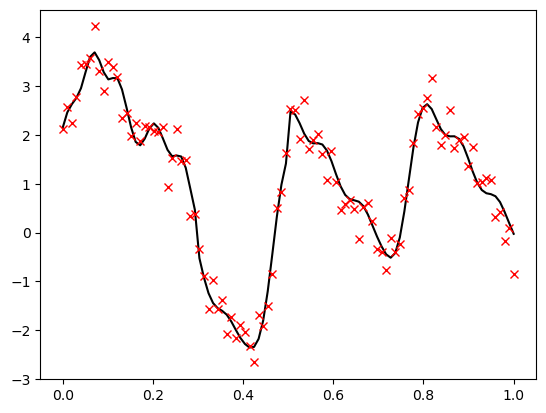

In [4]:
key = jrnd.PRNGKey(123456)

base_kernel1 = jk.RBF()
base_kernel2 = jk.Periodic()

# kernel = Discontinuous_multiple_params_hyper(base_kernel)
kernel = Discontinuous_multiple_params_hyper(base_kernel1) + Discontinuous_multiple_params_hyper_periodic(base_kernel2)

key, key1 = jrnd.split(key)
lengthscale1 = jnp.array([0.1, 1])
variance1 = jnp.array([2, 1])
lengthscale2 = jnp.array([0.4, 0.5])
variance2 = jnp.array([0.5, 2])
period = jnp.array([0.2, 0.3])
num1 = jnp.array([0.5])
num2 = jnp.array([0.3])

# params = dict(kernel1 =dict(lengthscale= lengthscale1,
#                             variance = variance1,
#                             num = num), 
#               kernel2 =dict(lengthscale= lengthscale2,
#                             variance = variance2,
#                             period = period, 
#                             num = num))
params = [dict(lengthscale= lengthscale1,
                            variance = variance1,
                            num = num1), 
              dict(lengthscale= lengthscale2,
                            variance = variance2,
                            period = period, 
                            num = num2)]
x = jnp.linspace(0, 1, 100)


K = kernel.cross_covariance(params, x, x)
# plt.imshow(K)
# plt.show()

n = 100
obs_noise_ = 0.3
L = jnp.linalg.cholesky(K+ 1e-6*jnp.eye(n))
z = jrnd.normal(key, shape=(n,))

f_true = jnp.dot(L, z) + jnp.ones_like(z)
key, obs_key = jrnd.split(key)
y = f_true + obs_noise_*jrnd.normal(obs_key, shape=(n,))


ground_truth = dict(f=f_true,
                    kernel = [dict(lengthscale=lengthscale1,
                                    variance=variance1,
                                    num = num1),
                             dict(lengthscale=lengthscale2,
                                    variance=variance2,
                                    period = period,
                                    num = num2)],
                    obs_noise=obs_noise_,
                    )


plt.plot(x, f_true, 'k', label=r'')
plt.plot(x, y, 'rx', label='obs')
plt.show()

In [5]:
key = jrnd.PRNGKey(123456)

size = 10
T = 1
max_CP = size
base_kernel1 = jk.RBF()
base_kernel2 = jk.Periodic()

# kernel = Discontinuous_multiple_params_hyper(base_kernel1)
# kernel = Discontinuous_multiple_params_hyper_periodic(base_kernel2)
kernel = Discontinuous_multiple_params_hyper(base_kernel1) + Discontinuous_multiple_params_hyper_periodic(base_kernel2)

# priors = dict(kernel=  [dict(lengthscale=LogNormal_mod(0, 2, max_CP+1),
#                              variance=LogNormal_mod(0, 2, max_CP+1),
#                              num=Poisson_Process_hyper(size, T)),
#                         dict(lengthscale=LogNormal_mod(0, 2, max_CP+1),
#                              variance=LogNormal_mod(0, 2, max_CP+1), 
#                              period=LogNormal_mod(0, 2, max_CP+1),
#                              num=Poisson_Process_hyper(size, T))],
#               likelihood=dict(obs_noise=dx.Transformed(dx.Normal(loc=0.,
#                                                                  scale=1.),
#                                                        tfb.Exp())),
#               hyper = [dict(hyper_1 = dx.Transformed(dx.Normal(loc=0.,
#                                                                scale=1.),
#                                                      tfb.Exp())), 
#                        dict(hyper_2 = dx.Transformed(dx.Normal(loc=0.,
#                                                                scale=1.),
#                                                      tfb.Exp()))])

priors = dict(kernel=  [dict(lengthscale=LogNormal_mod(0, 2, max_CP+1),
                             variance=LogNormal_mod(0, 2, max_CP+1),
                             num=Poisson_Process_hyper(size, T)),
                        dict(lengthscale=LogNormal_mod(0, 2, max_CP+1),
                             variance=LogNormal_mod(0, 2, max_CP+1), 
                             period=LogNormal_mod(0, 2, max_CP+1),
                             num=Poisson_Process_hyper(size, T))],
              likelihood=dict(obs_noise=LogNormal_mod(0, 1, 1)),
              hyper = [dict(hyper_1 = LogNormal_mod(0, 1, 1)), 
                       dict(hyper_2 = LogNormal_mod(0, 1, 1))])

x = jnp.linspace(0, 1, n)[:, jnp.newaxis]
gp_marginal = FullMarginalGPModelhyper_mult(x, y, cov_fn=kernel, priors=priors)  # Implies likelihood=Gaussian()

num_particles = 1000
num_mcmc_steps = 100

In [10]:
key, gpm_key = jrnd.split(key)
mgp_particles, _, mgp_marginal_likelihood = gp_marginal.inference(gpm_key,
                                                                  mode='gibbs-in-smc',
                                                                  sampling_parameters=dict(num_particles=num_particles, num_mcmc_steps=num_mcmc_steps), 
                                                                  poisson = True)

No Gibbs kernel available, defaulting to Random Walk Metropolis MCMC, sigma = 0.01


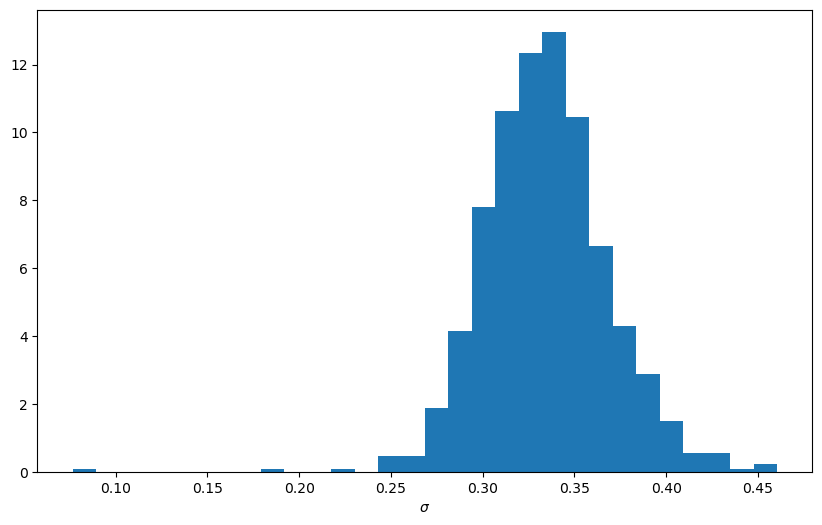

In [12]:
fig = plt.figure(figsize = (10, 6))
pd = mgp_particles.particles['likelihood']['obs_noise']
pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
pd_filtered = jnp.extract(pd>pd_l, pd)
pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)
plt.hist(pd, bins=30, density=True, color='tab:blue')
# plt.set_ylabel('obs_noise', rotation=0, ha='right')
plt.xlabel(r'${:s}$'.format('\sigma'))
plt.show()

KeyError: 0

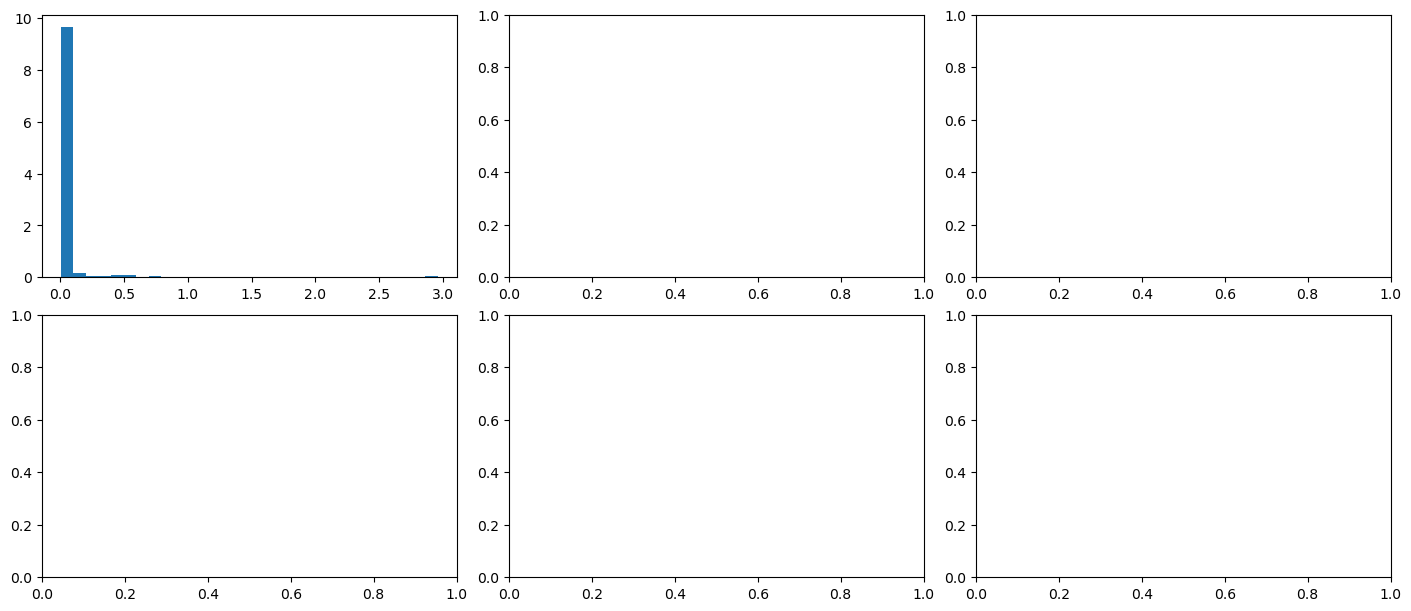

In [11]:
num_CPs = jnp.max(jnp.sum(~jnp.isnan(mgp_particles.particles['kernel'][0]['num']), axis = 1))
trainables = ['lengthscale', 'variance']
num_params = len(trainables)

# symbols = dict(lengthscale='\ell',
#             variance=r'\tau')
symbols = [fr'{name[0]}' for name in trainables]

num_CP = jnp.minimum(num_CPs, 5).tolist()

_, axes = plt.subplots(nrows=num_params, ncols=num_CP+1, constrained_layout=True,
                    figsize=(14, 6))


particles = mgp_particles
tr = dict(lengthscale=particles.particles['kernel'][0]['lengthscale'],
            variance=particles.particles['kernel'][0]['variance'],
            )
for j, var in enumerate(trainables):
    pd = tr[var]
    for i in range(num_CP+1):
      # There are some outliers that skew the axes
      # pd_u, pd_l = jnp.nanpercentile(pd[:, i], q=99.9), jnp.nanpercentile(pd[:, i], q=0.1)
      # pd_filtered = jnp.extract(pd[:, i]>pd_l, pd[:, i])
      # pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)
      axes[j, i].hist(pd[~jnp.isnan(pd[:, i]), i], bins=30, density=True, color='tab:blue')
      # axes[j, i].hist(pd[:, i][~jnp.isnan(pd[:, i])], bins=30, density=True, color='tab:blue')
      if ground_truth is not None:
        if len(ground_truth[0][var]) > i:
          axes[j, i].axvline(x=ground_truth[0][var][i], ls=':', c='k')
        
      for i, sym in enumerate(symbols):
        axes[i, j].set_xlabel(r'${:s}$'.format(f'{sym}_{j}'))


num_particles = 1000
plt.suptitle(f'Posterior estimate of Bayesian Marginal GP RBF kernel ({num_particles} particles)');

axes[0, 0].set_ylabel('lengthscale', rotation=0, ha='right')
axes[1, 0].set_ylabel('variance', rotation=0, ha='right')
plt.show()

'''--------------------------------------------------------------------'''
num_CPs = jnp.max(jnp.sum(~jnp.isnan(mgp_particles.particles['kernel'][1]['num']), axis = 1))
num_CP = jnp.minimum(num_CPs, 5).tolist()

trainables = ['lengthscale', 'variance', 'period']

num_params = len(trainables)

# symbols = dict( lengthscale='\ell',
#                 variance=r'\tau', 
#                 period = 'p')
symbols = [fr'{name[0]}' for name in trainables]
# print(symbols)

fig, axes = plt.subplots(nrows=num_params, ncols=num_CP+1, constrained_layout=True,
                    figsize=(14, 6))


# particles = mgp_particles
tr = dict(lengthscale=mgp_particles.particles['kernel'][1]['lengthscale'],
            variance=mgp_particles.particles['kernel'][1]['variance'],
            period = mgp_particles.particles['kernel'][1]['period']
            )
            
for j, var in enumerate(trainables):
    pd = tr[var]
    # There are some outliers that skew the axes
    # pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
    # pd_filtered = jnp.extract(pd>pd_l, pd)
    # pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)
    for i in range(num_CP+1):
      axes[j, i].hist(pd[:, i], bins=30, density=True, color='tab:blue')
      if ground_truth is not None:
        if len(ground_truth[1][var]) > i:
          axes[j, i].axvline(x=ground_truth[1][var][i], ls=':', c='k')

    for i, sym in enumerate(symbols):
        axes[i, j].set_xlabel(r'${:s}$'.format(f'{sym}_{j}'))


num_particles = 1000
plt.suptitle(f'Posterior estimate of Bayesian GP Periodic kernel ({num_particles} particles)');

axes[0, 0].set_ylabel('lengthscale', rotation=0, ha='right')
axes[1, 0].set_ylabel('variance', rotation=0, ha='right')
axes[2, 0].set_ylabel('period', rotation=0, ha='right')
plt.show()

# plt.savefig(f"{savename}/{savename}_posteriors_periodic")

In [16]:
r'${:s}$'.format(r'\tau')

'$\\tau$'

Text(0, 0.5, 'Marginal GP')

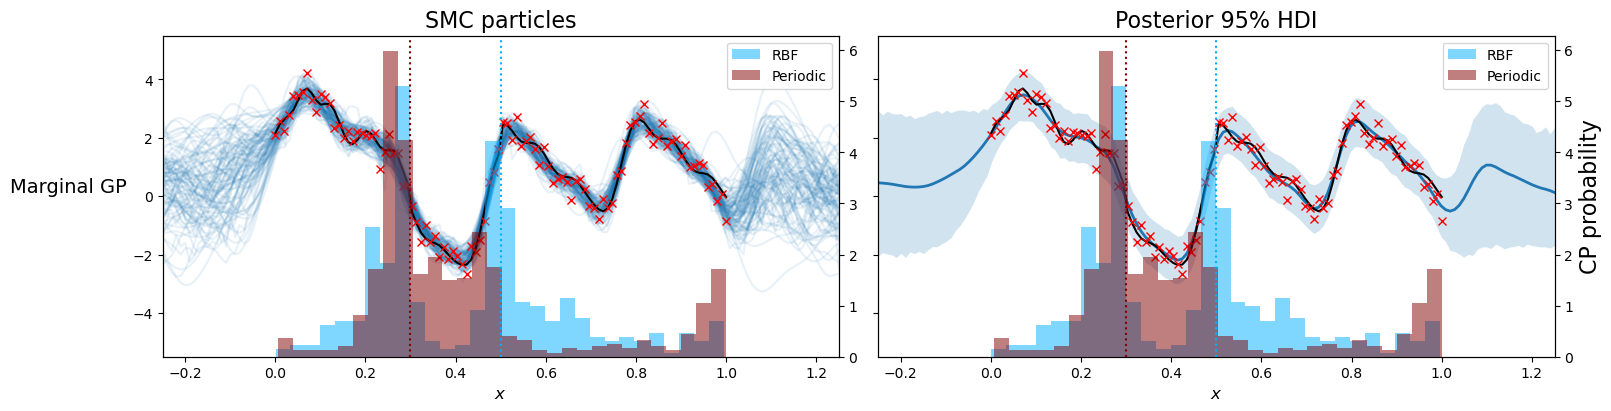

In [46]:
x_pred = jnp.linspace(-0.25, 1.25, num=150)

kernels = ['RBF', 'Periodic']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4), sharex=True,
                            sharey=True, constrained_layout=True)


key, key_pred = jrnd.split(key)
f_pred = gp_marginal.predict_f(key_pred, x_pred)


# There are some outliers that skew the axis
# pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
# pd_filtered = jnp.extract(pd>pd_l, pd)
# pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)

ax = axes[0]
for i in jnp.arange(0, num_particles, step=10):
    ax.plot(x_pred, f_pred[i, :], alpha=0.1, color='tab:blue')

colors = plt.cm.jet(jnp.linspace(0.3,1,2))
ax2 = ax.twinx()
for i, pd in enumerate(mgp_particles.particles['kernel']):
    new_pd = pd['num'][jnp.logical_not(jnp.isnan(pd['num']))]
    ax2.hist(new_pd, bins=30, density=True, color=colors[i], label = kernels[i], alpha=0.5)
    if ground_truth is not None:
        for CP in ground_truth[i]['num']:
            ax2.axvline(x=CP, ls=':', c=colors[i])
ax2.legend()

ax = axes[1]
f_mean = jnp.nanmean(f_pred, axis=0)
y_pred = gp_marginal.predict_y(key_pred, x_pred)
f_hdi_lower = jnp.nanpercentile(y_pred, q=2.5, axis=0)
f_hdi_upper = jnp.nanpercentile(y_pred, q=97.5, axis=0)
# f_hdi_lower = jnp.percentile(f_pred, q=2.5, axis=0)
# f_hdi_upper = jnp.percentile(f_pred, q=97.5, axis=0)

ax.plot(x_pred, f_mean, color='tab:blue', lw=2)
ax.fill_between(x_pred, f_hdi_lower, f_hdi_upper,
                alpha=0.2, color='tab:blue', lw=0)

#print(new_pd.shape)

ax2 = ax.twinx()
for i, pd in enumerate(mgp_particles.particles['kernel']):
    new_pd = pd['num'][jnp.logical_not(jnp.isnan(pd['num']))]
    ax2.hist(new_pd, bins=30, density=True, color=colors[i], alpha=0.5, label = kernels[i])
    for CP in ground_truth[i]['num']:
            ax2.axvline(x=CP, ls=':', c=colors[i])
ax2.legend()
ax2.set_ylabel('CP probability', fontsize=16)

for ax in axes.flatten():
    ax.plot(x, f_true, 'k', label=r'$f$')
    ax.plot(x, y, 'rx', label='obs')
    ax.set_xlim([-0.25, 1.25])
    ax.set_ylim([-5.5, 5.5])
    ax.set_xlabel(r'$x$', fontsize=12)

axes[0].set_title('SMC particles', fontsize=16)
axes[1].set_title('Posterior 95% HDI', fontsize=16)

axes[0].set_ylabel('Marginal GP', rotation=0, ha='right', fontsize=14)

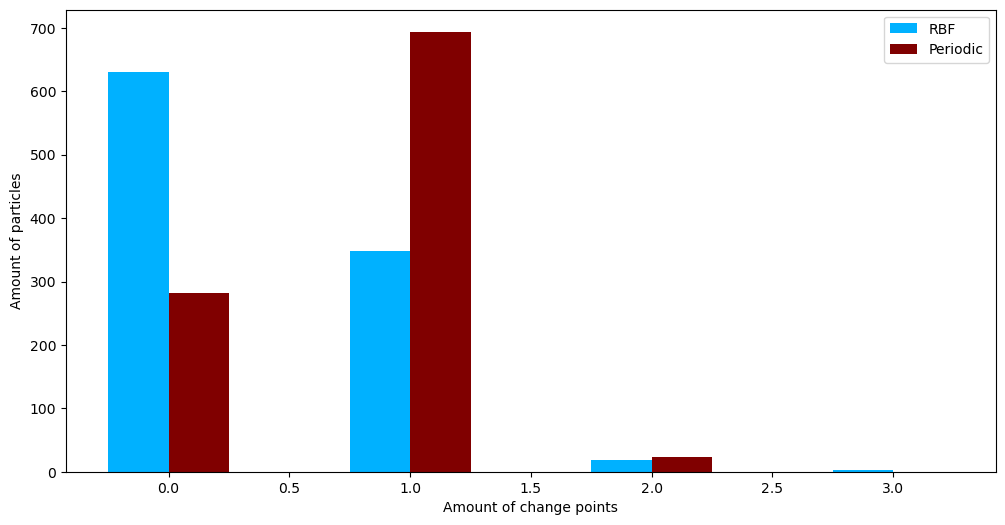

: 

In [47]:
fig = plt.figure(figsize=(12, 6))
colors = plt.cm.jet(jnp.linspace(0.3,1,2))
labels = ['RBF', 'Periodic']
counts = jnp.zeros((1000, 2))
for i, pd in enumerate(mgp_particles.particles['kernel']):
    num_val = pd['num']
    # print(num_val)
    counts = counts.at[:, i].set(jnp.count_nonzero(~jnp.isnan(num_val), axis = 1))
    uni_vals = jnp.sort(jnp.concatenate([jnp.unique(counts)-0.5, jnp.unique(counts)+0.5]))
plt.hist(counts.T, bins=uni_vals, rwidth = 0.5, color=colors, label=labels)
plt.xlabel("Amount of change points")
plt.ylabel("Amount of particles")
plt.legend()
plt.show()

## Test with new classes

In [6]:
sys.path.append('/home/davcic/CP_Testing/Classes')

from GP_CP import GP_CP_Marginal, GP_CP_Latent
num_particles = 1_000
num_mcmc_steps = 100
GP_marginal = GP_CP_Marginal(x, y, cov_fn=kernel, priors=priors, num_particles=num_particles, num_mcmc_steps=num_mcmc_steps)

In [7]:
GP_marginal.model_GP(key)

Running Marginal GP
No Gibbs kernel available, defaulting to Random Walk Metropolis MCMC, sigma = 0.01


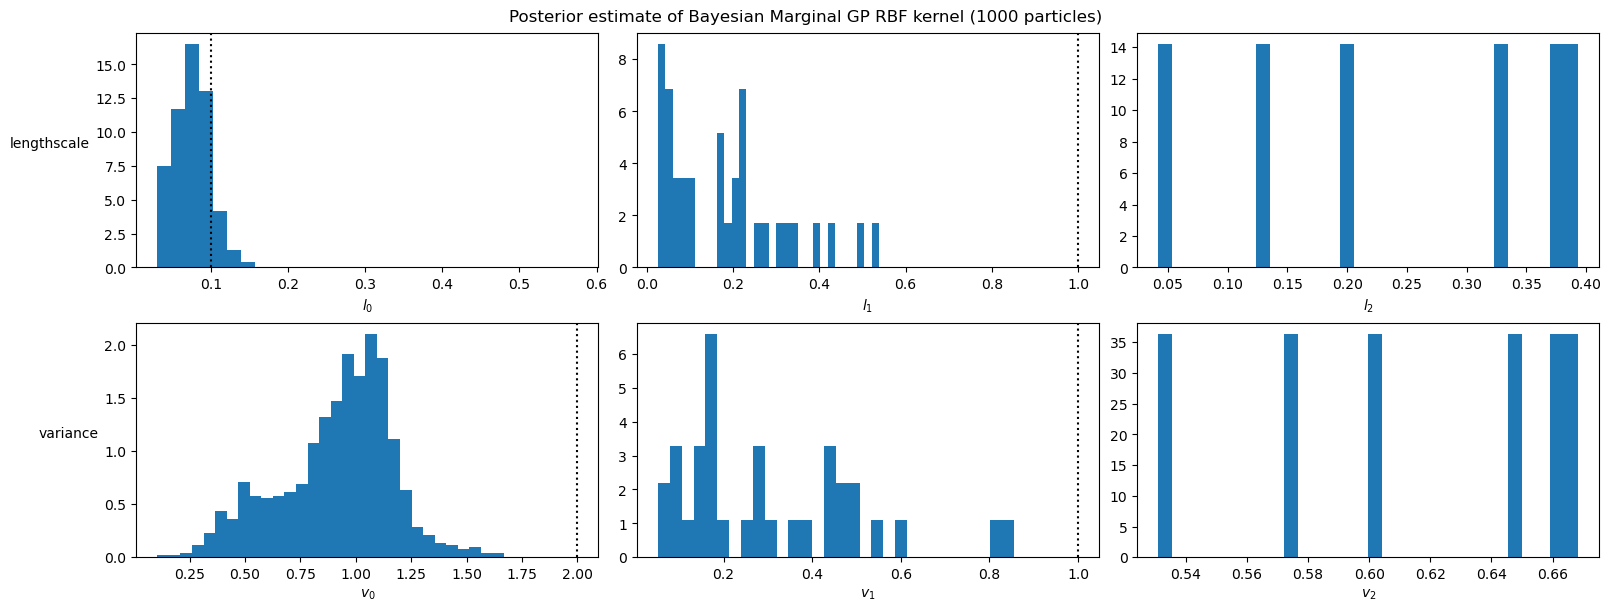

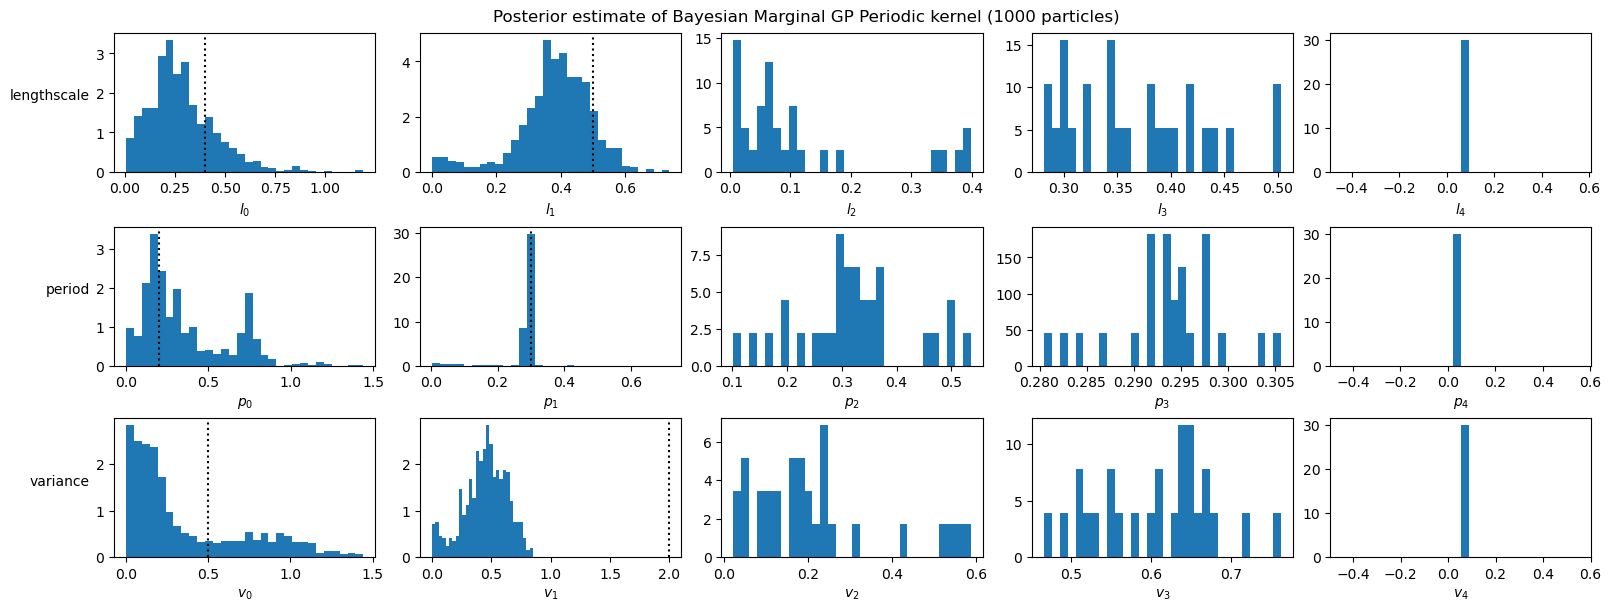

In [17]:
GP_marginal.plot_post(ground_truth)

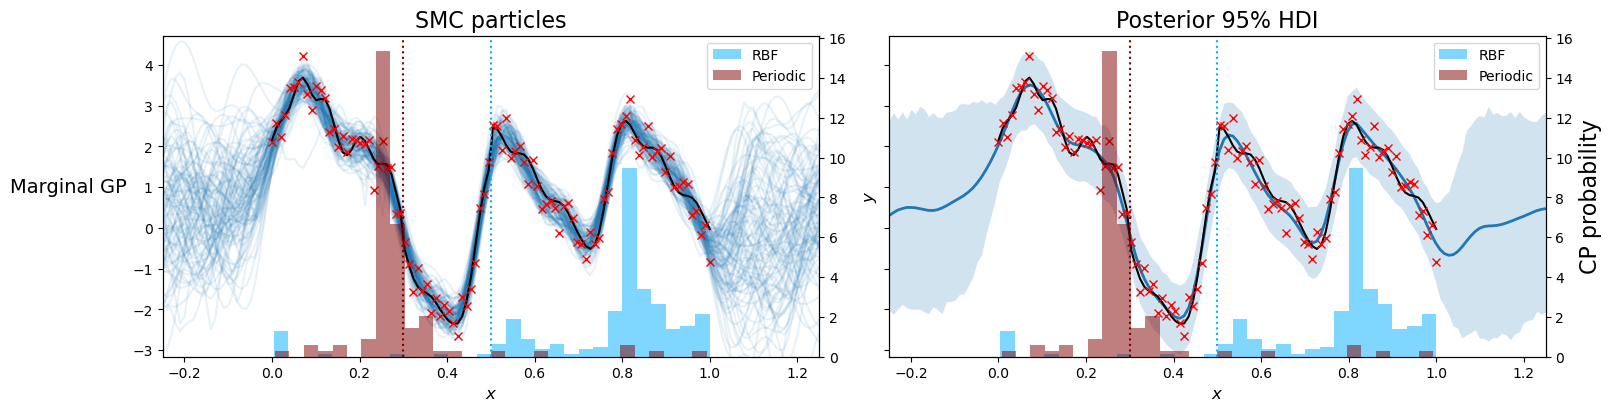

In [11]:
plt.style.use('default')
GP_marginal.plot_fit(key, True, f_true, ground_truth)

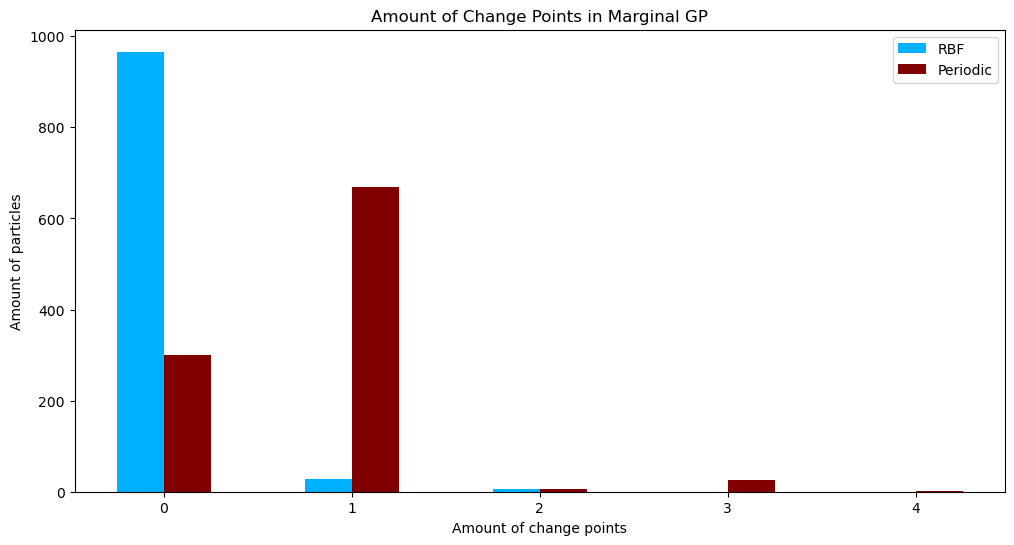

In [19]:
GP_marginal.plot_num()

In [110]:
print(f'number metric {GP_marginal.number_metric(ground_truth)}')
print(f'likelihood metric {GP_marginal.likelihood_metric(key)}')

number metric {'RBF': -0.0908888888888889, 'Periodic': -0.10244444444444445}
likelihood metric -25.772376275425017


In [111]:
print(f'jaccard metric {GP_marginal.jaccard_metric(ground_truth)}')

jaccard metric {'RBF': 0.4910686, 'Periodic': 0.4003362}


In [120]:
print(f'location metric {GP_marginal.location_metric(ground_truth)}')

location metric {'RBF': 0.09296355503076732, 'Periodic': 0.0932907422896193}


In [59]:
# params = [dict(lengthscale= lengthscale1,
#                             variance = variance1,
#                             num = num1), 
#               dict(lengthscale= lengthscale2,
#                             variance = variance2,
#                             period = period, 
#                             num = num2)]
# truth_K = GP_marginal.cov_fn.cross_covariance(params, GP_marginal.X.flatten(), GP_marginal.X.flatten())
# plt.imshow(jnp.reshape(jax.vmap(lambda x: jax.lax.cond(x > 0, lambda: 1, lambda: 0))(truth_K.flatten()), (len(GP_marginal.X), len(GP_marginal.X))))

In [38]:
num_particles = 1000
num_mcmc_steps = 100
GP_latent = GP_CP_Latent(x, y, cov_fn=kernel, priors=priors, num_particles=num_particles, num_mcmc_steps=num_mcmc_steps)

In [39]:
GP_latent.model_GP(key)

Running Latent GP


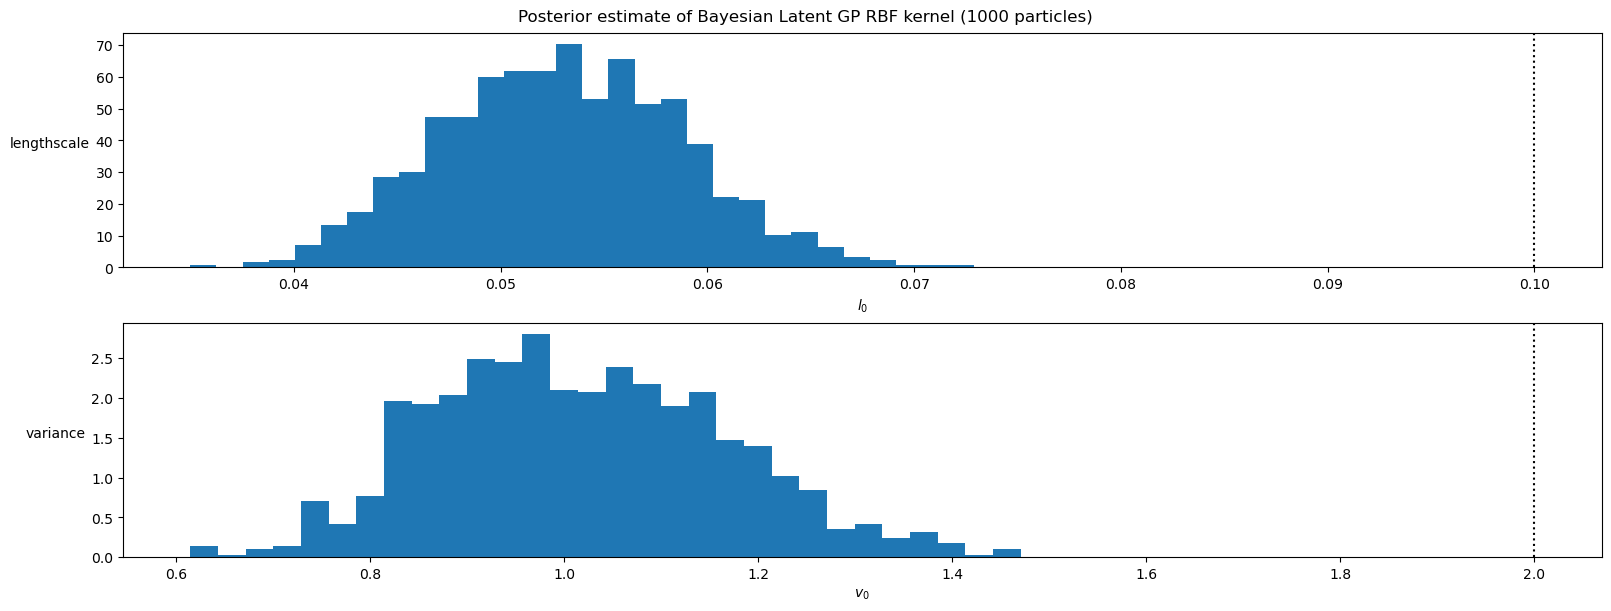

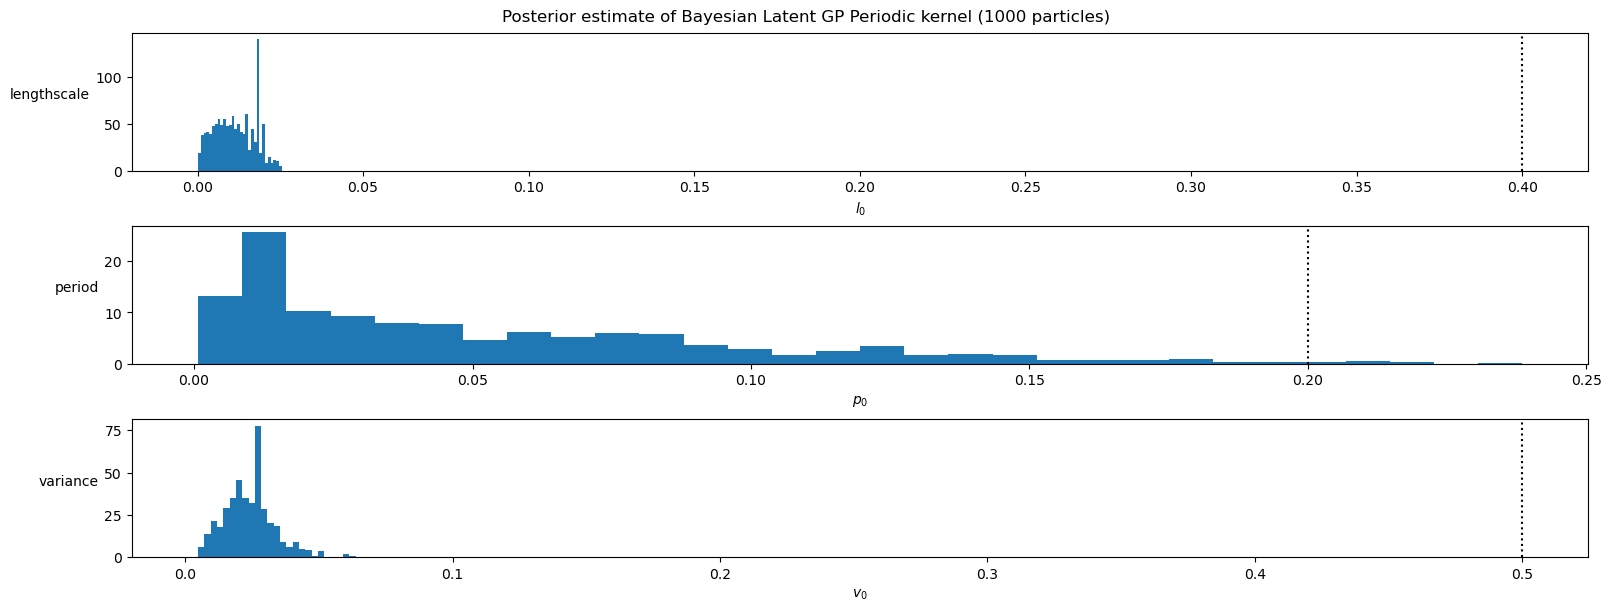

In [40]:
GP_latent.plot_post(ground_truth)

/home/davcic/.conda/envs/CPJax/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


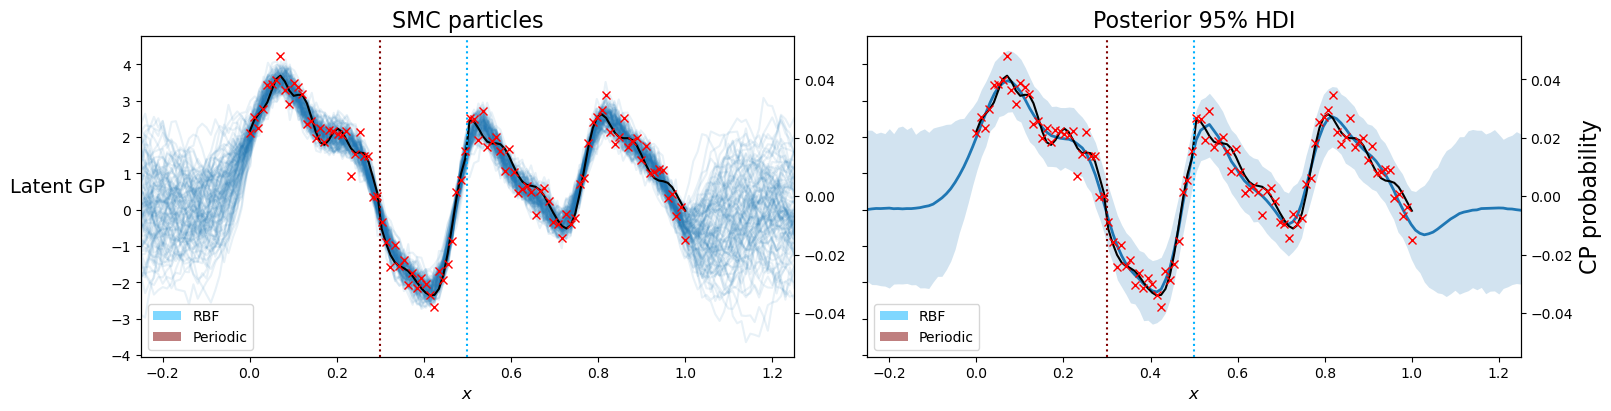

In [41]:
GP_latent.plot_fit(key, True, f_true, ground_truth)

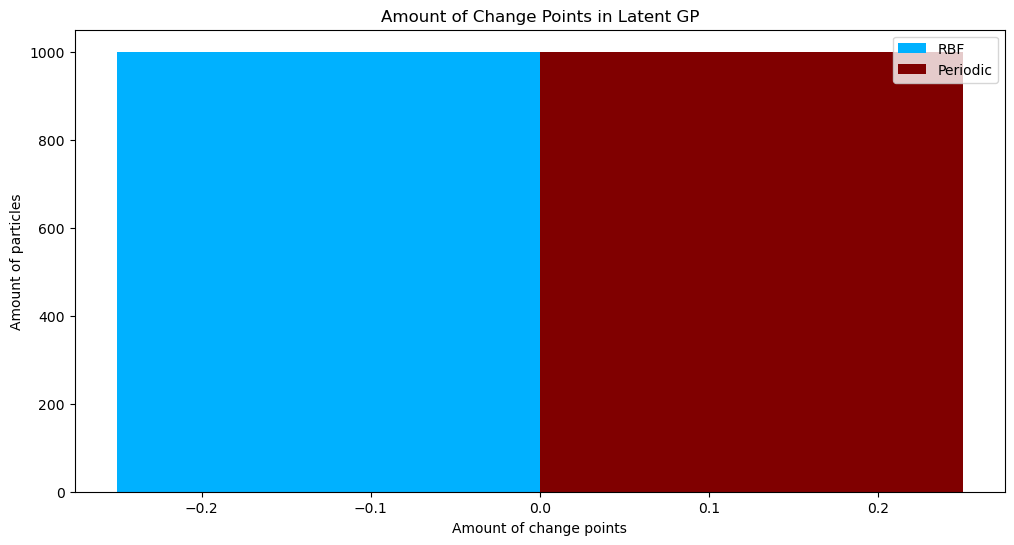

In [42]:
GP_latent.plot_num()

In [37]:
print(GP_latent.number_metric(ground_truth))
print(GP_latent.location_metric(ground_truth))
print(GP_latent.likelihood_metric(key))
print(GP_latent.jaccard_metric(ground_truth))

{'RBF': 0.11022222222222222, 'Periodic': 0.11088888888888888}
{'RBF': 0.10000000000000003, 'Periodic': 0.10000000000000003}
-36.81661895596105
{'RBF': 0.0, 'Periodic': 0.0}
